# Creating a Molecule's Potential Energy Curve

A potential energy curve gives the ground energy of an assemble of atoms as function of the distances between them. The global minima of the curve indicates the binding energy and internuclear distance for the stable molecule. Therefor, such curve can be powerful tool in computational chemistry, for predicting molecular structure and spectrum.

In this tutorial, we will demonstrate how, using Classiq's VQE package, the user can create a Molecule's potential energy curve, and compare the result those of the Hartree-Fock approximative method and to the exact results. The exact solution is a result of diagonalizing the Hamiltonian.

## 0. Pre-requirments

The model is using several Classiq's libraries in addition to IBM's simulating tool.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

from classiq import construct_chemistry_model, execute, show, synthesize
from classiq.applications.chemistry import (
    ChemistryExecutionParameters,
    HEAParameters,
    Molecule,
    MoleculeProblem,
    UCCParameters,
)
from classiq.execution import OptimizerType

## 1. Defintions and Initialization

Here, we define the range of internuclear distances for the model to simulate, and chose the number of sampling point in this range, which determines the graph's resolution.

In [2]:
# define the sampling params
num1 = 5  # how many sampling points - determines your resolution
start1 = 0.20  # what is your sampling start distance
stop1 = 1  # what is your sampling end distance
num2 = 7  # how many sampling points - determines your resolution
start2 = 1.4  # what is your sampling start distance
stop2 = 3.5  # what is your sampling end distance


# prepare x,y vectors
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2))
VQE_energy = []
HF_energy = []
exact_energy = []

print(distance)

[0.2  0.4  0.6  0.8  1.   1.4  1.75 2.1  2.45 2.8  3.15 3.5 ]


## 2. Energy Estimations

Here we define a for-loop, which does the following steps:

a. creating molecule at changing distances between the atoms.

b. Constructing a chemistry model for the corresponding Hamiltonian, using Hartree-Fock initial state and UCC ansatz.

c. Synthesizing the model to get a quantum program.

d. Executing the quantum program to extract a solution for the ground energy.

e. Obtain the exact solution and Hartree-Fock solution.

In [3]:
# create the molecule, insert the distance, prepare H, create UCC anzats and solve in energy
for x in distance:
    time1 = time.time()

    molecule = Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, float(x)))])

    chemistry_problem = MoleculeProblem(
        molecule=molecule,
        mapping="jordan_wigner",  # 'bravyi_kitaev'
        z2_symmetries=True,
        freeze_core=True,
    )

    qmod = construct_chemistry_model(
        chemistry_problem=chemistry_problem,
        use_hartree_fock=True,
        ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(
            optimizer=OptimizerType.COBYLA,
            max_iteration=30,
            initial_point=None,
        ),
    )

    qprog = synthesize(qmod)

    result = execute(qprog).result()
    chemistry_result_dict = result[1].value

    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]

    VQE_energy.append(chemistry_result_dict["total_energy"])

    HF_energy.append(chemistry_result_dict["hartree_fock_energy"])

    exact_energy.append(result_exact)

    time2 = time.time()
    print(time2 - time1)

10.898590564727783


11.747302770614624


12.790097713470459


11.918429136276245


10.73127555847168


13.76307225227356


11.681713104248047


10.668424606323242


12.745018720626831


12.173685312271118


10.815608501434326


10.709745407104492


In [4]:
# save the last model to a qmod file
from classiq import write_qmod

write_qmod(qmod, name="molecular_energy_curve")

## 3. Create Graph

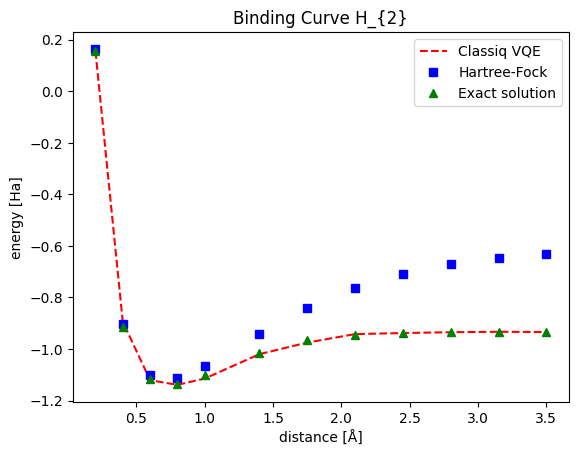

In [5]:
plt.plot(
    distance, VQE_energy, "r--", distance, HF_energy, "bs", distance, exact_energy, "g^"
)

plt.xlabel("distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Hartree-Fock", "Exact solution"])
plt.title("Binding Curve H_{2}")

plt.show()

This graph presents the ground state for $H_{2}$ molecule as a function of the distance between the two hydrogen atoms. One can see that both the HF solution and Classiq VQE present decent results around the global minima. For further distances, Classiq VQE stays close to the exact solution while the HF solution gradually deviates. The source of this lack of correspondence is with the lack of flexible correlations within the HF model, which is enabled within VQE scope.
One can similarly create graphs for different molecules (even n- dimensional or larger atom assemblies), to explore more curves.
